In [1]:
import pandas as pd
import numpy as np
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
import functools 
warnings.filterwarnings('ignore')
%matplotlib inline

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Gathering Data

In [3]:
#reading twitter archive into a pandas dataframe
archive = pd.read_csv("twitter-archive-enhanced.csv")

In [4]:
#downloading the image_predictions.tsv file programmatically 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = 'image_predictions'
response = requests.get(url)
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)
df_image = pd.read_csv('image-predictions.tsv',sep='\t')

In [5]:
#reading the tweet-json.txt file directly as I was not granted permission for a twitter developer account
tweets = []
with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        tweets.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count})
api_df = pd.DataFrame(data=tweets)

# Assessing Data
### Visual Assessment:
using sample, head and tail functions.

In [6]:
#viewing the archive dataframe
archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
286,838831947270979586,NaN,NaN,2017-03-06 19:21:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Riley. His owner put a ...,7.838400e+17,4.196984e+09,2016-10-06 01:23:05 +0000,https://twitter.com/dog_rates/status/783839966...,13,10,Riley,None,None,None,None
920,756303284449767430,NaN,NaN,2016-07-22 01:42:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pwease accept dis rose on behalf of dog. 11/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756303284...,11,10,None,None,None,None,None
1477,693622659251335168,NaN,NaN,2016-01-31 02:31:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you keepin the popcorn bucket in your lap...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693622659...,10,10,None,None,None,None,None
918,756651752796094464,NaN,NaN,2016-07-23 00:46:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gert. He just wants you to be happy. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756651752...,11,10,Gert,None,None,None,None
2024,671891728106971137,NaN,NaN,2015-12-02 03:20:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mojo. Apparently he's too cute for a s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671891728...,11,10,Mojo,None,None,None,None
432,820749716845686786,NaN,NaN,2017-01-15 21:49:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sunny. He can take down a polar bear in o...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820749716...,13,10,Sunny,None,None,None,None
1597,686050296934563840,NaN,NaN,2016-01-10 05:01:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Flávio. He's a Macedonian Poppycock. 9...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686050296...,11,10,Flávio,None,None,None,None
2198,668815180734689280,NaN,NaN,2015-11-23 15:35:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a wild Toblerone from Papua New Guinea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668815180...,7,10,a,None,None,None,None
1241,712065007010385924,NaN,NaN,2016-03-21 23:55:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chester. He's clearly in charge of the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712065007...,6,10,Chester,None,None,None,None


In [7]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [9]:
#viewing the image predictions dataframe
df_image.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
336,672222792075620352,https://pbs.twimg.com/media/CVQ3EDdWIAINyhM.jpg,1,beagle,0.958178,True,basset,0.009117,True,Italian_greyhound,0.007731,True
1017,709918798883774466,https://pbs.twimg.com/media/CdojYQmW8AApv4h.jpg,2,Pembroke,0.956222,True,Cardigan,0.020727,True,Chihuahua,0.007912,True
154,668779399630725120,https://pbs.twimg.com/media/CUf7UIaWUAEuKFr.jpg,1,Chesapeake_Bay_retriever,0.285508,True,Weimaraner,0.146832,True,black-footed_ferret,0.060865,False
1116,725729321944506368,https://pbs.twimg.com/media/ChJO9YaWYAEL0zC.jpg,1,boxer,0.599076,True,bull_mastiff,0.177318,True,French_bulldog,0.141461,True
327,671896809300709376,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
1400,768609597686943744,https://pbs.twimg.com/media/CqqmWa7WcAAIM-n.jpg,1,basenji,0.183283,True,Italian_greyhound,0.136012,True,whippet,0.060130,True
1649,809084759137812480,https://pbs.twimg.com/media/CzpyM41UoAE1b2w.jpg,1,vizsla,0.911412,True,bloodhound,0.017134,True,Labrador_retriever,0.011761,True
1411,770772759874076672,https://pbs.twimg.com/media/CrJVupHXgAA4Dkk.jpg,1,chow,0.979515,True,golden_retriever,0.010219,True,Pomeranian,0.004606,True
1783,829011960981237760,https://pbs.twimg.com/media/C4E99ygWcAAQpPs.jpg,2,boxer,0.312221,True,dalmatian,0.244040,True,conch,0.130273,False
976,707021089608753152,https://pbs.twimg.com/media/Cc_XtkRW8AEE7Fn.jpg,2,cocker_spaniel,0.559658,True,golden_retriever,0.314673,True,Pekinese,0.066672,True


In [10]:
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [11]:
df_image.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [12]:
#viewing the twitter api dataframe
api_df.sample(10)

,favorite_count,retweet_count,tweet_id,user_count
662,18601,5496,790946055508652032,3200901
1932,1676,714,674014384960745472,3201004
1129,3460,917,728986383096946689,3200944
652,8029,2088,792050063153438720,3200901
159,0,882,860924035999428608,3200891
582,0,4581,800188575492947969,3200898
1050,4878,2245,742528092657332225,3200943
964,5005,1309,750383411068534784,3200943
1354,4162,1559,703425003149250560,3200949
463,6267,1131,817415592588222464,3200894


In [13]:
api_df.head()

,favorite_count,retweet_count,tweet_id,user_count
0,39467,8853,892420643555336193,3200889
1,33819,6514,892177421306343426,3200889
2,25461,4328,891815181378084864,3200889
3,42908,8964,891689557279858688,3200889
4,41048,9774,891327558926688256,3200889


In [14]:
api_df.tail()

,favorite_count,retweet_count,tweet_id,user_count
2349,111,41,666049248165822465,3201018
2350,311,147,666044226329800704,3201018
2351,128,47,666033412701032449,3201018
2352,132,48,666029285002620928,3201018
2353,2535,532,666020888022790149,3201018


### Programmatic Assessment:
using info, shape and describe functions.

In [15]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
archive.shape

(2356, 17)

In [17]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
#programmatic assessment of image predictions datatframe
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
df_image.shape

(2075, 12)

In [20]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [21]:
#programmatic assessment of twitter api datatframe
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
user_count        2354 non-null int64
dtypes: int64(4)
memory usage: 73.6 KB


In [22]:
api_df.shape

(2354, 4)

In [23]:
api_df.describe()

,favorite_count,retweet_count,tweet_id,user_count
count,2354.000000,2354.000000,2.354000e+03,2.354000e+03
mean,8080.968564,3164.797366,7.426978e+17,3.200942e+06
std,11814.771334,5284.770364,6.852812e+16,4.457302e+01
min,0.000000,0.000000,6.660209e+17,3.200799e+06
25%,1415.000000,624.500000,6.783975e+17,3.200898e+06
50%,3603.500000,1473.500000,7.194596e+17,3.200945e+06
75%,10122.250000,3652.000000,7.993058e+17,3.200953e+06
max,132810.000000,79515.000000,8.924206e+17,3.201018e+06


# Issues

## Quality Issues:

### In the archive dataframe: 

• Some tweets are replies.

• Some tweets are retweets.

• 'expanded_urls' column has missing values.

• Timestamps have ‘+0000’ at the end of it.

• Timestamps columns should be of datetime type.

• Some dogs are named ‘a’, ‘an’, ‘such’, ‘quite' etc.

• incorrect fractional rating numerator extractions where the number after the decimal point is the one extracted.

• 'ratings_denominator' column values not always 10, some large values represent ratings for several dogs in 1 tweet and values less than 10 are erroneously extracted.


### In the image predictions dataframe:

• All three predictions of some tweets are false (not dog breeds).

• there's a discrepancy in the rows of the archive and the image predictions datatframe


## Tidiness Issues:

### In the archive dataframe: 

• The doggo/floofer.. columns should be in one column (some have null values in all columns and others have 2 values)

### In the image predictions dataframe:

• Only the most accurate dog breed prediction should be represented in the dataframe in one column.

### In the twitter api dataframe:

•This dataframe should be joined in the same table as archive df.


In [24]:
#making copies of the dataframes for cleaning
archive_clean = archive.copy()
image_clean = df_image.copy()
api_clean = api_df.copy()

# Cleaning Data

## Define:

### in the archive dataframe:

• remove the tweets that are replies by removing non-missing value in 'in_reply_to_status_id' and 'in_reply_to_user_id' columns using isnull() function

• remove the ones that are retweets by removing non-missing values in 'retweeted_status_id' and 'retweeted_status_user_id' columns using isnull() function

## Code

In [25]:
archive_clean = archive_clean[archive_clean['in_reply_to_status_id'].isnull()]
archive_clean = archive_clean[archive_clean['in_reply_to_user_id'].isnull()]
archive_clean = archive_clean[archive_clean['retweeted_status_id'].isnull()]
archive_clean = archive_clean[archive_clean['retweeted_status_user_id'].isnull()]

## Test

In [26]:
archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [27]:
#droping the replies and retweets columns 
archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace = True)

# Clean

## Define:

In the archive dataframe:

• remove tweets/rows with null values in the 'expanded_urls' column using pandas dropna() function


## Code

In [28]:
archive_clean = archive_clean.dropna(subset=['expanded_urls'])

## Test

In [29]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null object
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: int64(3), object(9)
memory usage: 212.7+ KB


# Clean

## Define:

In the archive dataframe:

• remove +0000 at the end of the 'timestamp' column using string slicing and removing the last 5 characters

• convert the timestamp column from type string to datetime using pandas.to_datetime function

## Code

In [30]:
archive_clean['timestamp'] = archive_clean['timestamp'].str[:-5]

In [31]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

## Test

In [32]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [33]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 212.7+ KB


# Clean

## Define:

In the archive dataframe:

• Recapture dog names in the archive dataframe using re.compile and re.findall functions along with regex to capture words after 'named' or 'name is' for the dog names ‘a’, ‘an’, ‘such’, ‘quite' etc. and setting the null values to the string 'None' to match other null values in the dog name column. 


## Code

In [34]:
pattern = re.compile(r"(?:name is|named)\s(\w+)")

for index, row in archive_clean.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('an', c_name)
    except IndexError:
        archive_clean.loc[index,'name'] = np.nan

            
archive_clean.name.value_counts(dropna = False)

None         600
NaN           40
Lucy          11
Charlie       11
Oliver        10
Cooper        10
Tucker         9
Penny          9
Winston        8
the            8
Lola           8
Sadie          8
Toby           7
Daisy          7
Bailey         6
Bella          6
Koda           6
Stanley        6
Oscar          6
Bo             6
Jax            6
Leo            5
Louis          5
Buddy          5
Dave           5
Chester        5
Rusty          5
Bentley        5
Scout          5
Milo           5
            ... 
Mimosa         1
Banditt        1
Acro           1
Kenny          1
Grizzwald      1
Rupert         1
Apollo         1
Alf            1
Perry          1
Socks          1
Jangle         1
DonDon         1
Chaz           1
by             1
Jessifer       1
Brat           1
Stormy         1
Franq          1
Arlen          1
Striker        1
Eazy           1
Harrison       1
Shaggy         1
Pavlov         1
Comet          1
Combo          1
Kloey          1
Sweet         

In [35]:
archive_clean['name'].fillna('None', inplace = True)

## Test

In [36]:
archive_clean['name']

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
20        Gerald
21       Jeffrey
22          such
23        Canela
24          None
25          None
26          Maya
27        Mingus
28         Derek
29        Roscoe
31       Waffles
          ...   
2326       quite
2327        None
2328        None
2329        None
2330        None
2331        None
2332        None
2333        None
2334        None
2335        None
2336        None
2337        None
2338        None
2339        None
2340        None
2341        None
2342        None
2343        None
2344        None
2345         the
2346         the
2347        None
2348        None
2349        None
2350        None
2351        None
2352        None
2353        No

# Clean

## Define:

In the archive dataframe:

• combining the 'doggo', 'floofer', 'pupper', 'puppo' columns of the archive dataframe into one column by:
1.replacing the string 'None' with empty string ' ' with replace function

2.adding the columns into one column named 'dog_stage'.

3.dropping the other columns and separating rows with 2 dog stages with a '-' using drop function.

4.replace empty string values " " with null values with replace function.

## Code

In [37]:
archive_clean['doggo'] = archive_clean['doggo'].replace({'None':""})
archive_clean['floofer'] = archive_clean['floofer'].replace({'None':""})
archive_clean['pupper'] = archive_clean['pupper'].replace({'None':""})
archive_clean['puppo'] = archive_clean['puppo'].replace({'None':""})

In [38]:
archive_clean['dog_stage'] = archive_clean['doggo'] + archive_clean['floofer'] + archive_clean['pupper'] + archive_clean['puppo']

In [39]:
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [40]:
archive_clean['dog_stage'].replace(to_replace='doggopupper', value= 'doggo-pupper', inplace=True)
archive_clean['dog_stage'].replace(to_replace='doggofloofer', value= 'doggo-floofer', inplace=True)
archive_clean['dog_stage'].replace(to_replace='doggopuppo', value= 'doggo-puppo', inplace=True)

In [41]:
archive_clean['dog_stage'].replace('', np.nan, inplace= True)

## Test

In [42]:
archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


# Clean

## Define:

In the archive dataframe:

• extracting the correct values of the 'rating_numerator' column in the archive dataframe from the text by using a regex and capturing the ratings numerator values using str.extract function and converting them to type float


## Code

In [43]:
archive_clean['rating_numerator'] = archive_clean.text.str.extract('(\d+\.?\d?\d?)\/\d{1,3}', expand = False).astype('float')

## Test

In [44]:
archive_clean['rating_denominator'].value_counts()

10     2077
50        3
11        2
80        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

# Clean

## Define:

In the archive dataframe:

• fixing the 'rating_denominator' values that are not '10' (for analysis and visualization purposes):

1. the denominator of value 7 refers to 24/7 which is not a rating and it will be removed as there is no rating in the text by iterating through the rows and replacing the numerator 24 with 0 and the denominator 7 with 0

2. However in instances (as 9/11, 4/20 these are dates, 7/11 is a store and 50/50 and 1/2 for measurement) the rating is actually furthur down the text so to fix this I will iterate through all the rows with regex negative lookahead and replacing the numerator and denominator values 

3. the instances where numbers are higher than 40 is when there are multiple dogs in the picture so 'rating_denominator' as well as 'rating_numerator' column will be adjusted and fixing this programmatically can be done by calculating the dog count for each tweet with ratings over 40 then dividing each ratings column value for these tweets by the calculated dog count.



## Code

In [45]:
#converting the the rating columns to strings for ease of using replace function
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].apply(str)
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].apply(str)

In [46]:
#replacing the 24/7 rating manually as it is a one-off occurence and there's no rating in this tweet
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].replace('7','0')
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].replace('24','0')

In [47]:
#negative lookahead regex for the numerator and the denominator values
num_pattern = re.compile(r"(\d+\.?\d?\d?)\/\d{1,3}(?!.*\d+\.?\d?\d?\/\d{1,3})")
den_pattern = re.compile(r"\d+\.?\d?\d?\/(\d{1,3})(?!.*\d+\.?\d?\d?\/\d{1,3})")

#iterating through rows with the erroneous rating based on denominator number
for index, row in archive_clean.iterrows():  
        if row['rating_denominator'] == "11":
            den_rating = re.findall(den_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_denominator'] = archive_clean.loc[index,'rating_denominator'].replace('11', den_rating)
            num_rating = re.findall(num_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_numerator'] = archive_clean.loc[index,'rating_numerator'].replace('7', num_rating)
        
        elif row['rating_denominator'] == "11":
            den_rating = re.findall(den_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_denominator'] = archive_clean.loc[index,'rating_denominator'].replace('11', den_rating)
            num_rating = re.findall(num_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_numerator'] = archive_clean.loc[index,'rating_numerator'].replace('9', num_rating)
        
        elif row['rating_denominator'] == "20":
            den_rating = re.findall(den_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_denominator'] = archive_clean.loc[index,'rating_denominator'].replace('20', den_rating)
            num_rating = re.findall(num_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_numerator'] = archive_clean.loc[index,'rating_numerator'].replace('4', num_rating)
        
        elif row['rating_denominator'] == "50":
            den_rating = re.findall(den_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_denominator'] = archive_clean.loc[index,'rating_denominator'].replace('50', den_rating)
            num_rating = re.findall(num_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_numerator'] = archive_clean.loc[index,'rating_numerator'].replace('50', num_rating)
            
        elif row['rating_denominator'] == "2":
            den_rating = re.findall(den_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_denominator'] = archive_clean.loc[index,'rating_denominator'].replace('2', den_rating)
            num_rating = re.findall(num_pattern, row['text'])[0]
            archive_clean.loc[index,'rating_numerator'] = archive_clean.loc[index,'rating_numerator'].replace('1', num_rating)

In [48]:
#converting ratings values back to int type in order to divide them by their dog count
archive_clean['rating_numerator'] = pd.to_numeric(archive_clean['rating_numerator'])
archive_clean['rating_denominator'] = pd.to_numeric(archive_clean['rating_denominator'])

In [49]:
# Calculating the dogs counts in the tweets featuring 40 or more ratings (several dogs)
for index, row in archive_clean.iterrows(): 
    if row['rating_denominator'] >= 40:
        dogs_count = archive_clean['rating_denominator']/10

# Performing the Calculations
archive_clean.loc[archive_clean.rating_numerator >= 40, ['rating_numerator', 'rating_denominator']] = [archive_clean.rating_numerator[archive_clean.rating_numerator >= 40]/dogs_count , 10]

## Test

In [50]:
archive_clean['rating_denominator'].value_counts()

10    2093
0        1
Name: rating_denominator, dtype: int64

# Clean

## Define:

Matching the tweet ids for the archive and image predictions dataframe:

• check for unique tweets in the image predictions data frame that are not in the archive data frame and vice versa (meaning there are tweets that are replies/retweets in the image predictions dataframe or there are tweets with images that were not included in the archive dataframe)

This will be done by making a list of unique 'tweet_id' entries for each datatframe and whitlling down the other dataframe using the unique() function and the isin() function


## Code

In [51]:
tweets_with_image = list(image_clean.tweet_id.unique())
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_image)]

In [52]:
unique_archive_tweets = list(archive_clean.tweet_id.unique())
image_clean = image_clean[image_clean.tweet_id.isin(unique_archive_tweets)]

## Test

In [53]:
archive_clean.shape

(1971, 9)

In [54]:
image_clean.shape

(1971, 12)

# Clean

## Define:

In the image predictions dataframe:

• reshaping the prediction columns in the image predictions dataframe by:

1. renaming the columns to be more clearer and using the pandas wide_to_long function where each tweet will be duplicated for each entry.

2. choosing the image prediction with the most confidence by using pandas groupby to group by tweet id where confidence is max in a series called 'breed' then whitlling the image predictions dataframe with the resulting series

3. removing rows where value in 'breed' column is false using boolean expressions

4. Dropping 'breed' column and renaming 'prediction' column 'breed' for clarity


## Code

In [55]:
# Renaming the dataset columns
cols = ['tweet_id', 'jpg_url', 'img_num', 
       'prediction_1', 'confidence_1', 'breed_1',
       'prediction_2', 'confidence_2', 'breed_2',
       'prediction_3', 'confidence_3', 'breed_3']
image_clean.columns = cols

# Reshaping the dataframe
image_clean = pd.wide_to_long(image_clean, stubnames=['prediction', 'confidence', 'breed'], 
    i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_level', sep="_").reset_index()

In [56]:
breed = image_clean.groupby(['tweet_id']).confidence.max()

In [57]:
image_clean = image_clean[image_clean.confidence.isin(breed)]

In [58]:
image_clean = image_clean[image_clean.breed != False]

In [59]:
image_clean.drop('breed', axis=1, inplace=True)

In [60]:
image_clean.rename(columns={"prediction": "breed"}, inplace=True)

## Test

In [61]:
image_clean

,tweet_id,jpg_url,img_num,prediction_level,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826
6,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,1,German_shepherd,0.596461
9,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,1,Rhodesian_ridgeback,0.408143
12,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,1,miniature_pinscher,0.560311
15,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,1,Bernese_mountain_dog,0.651137
21,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,1,chow,0.692517
27,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,1,miniature_poodle,0.201493
30,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,1,golden_retriever,0.775930
33,666071193221509120,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1,1,Gordon_setter,0.503672


# Clean

## Define:

Merging all dataframes into one:

1. Matching image and api dataframe indexes:
check for unique tweets in the image predictions data frame that are not in the api data frame and vice versa by making a list of unique 'tweet_id' entries for each datatframe and whitlling down the other dataframe using the unique() function and the isin() function

2. Matching archive and api dataframe indexes:


3. Matching archive and image dataframe indexes:

## Code

In [62]:
#Matching image and api dataframe indexes
image_list = list(image_clean.tweet_id.unique())
api_clean = api_clean[api_clean.tweet_id.isin(image_list)]
api_data = list(api_clean.tweet_id.unique())
image_clean = image_clean[image_clean.tweet_id.isin(api_data)]
api_for_images = api_clean.copy()

In [63]:
#Matching archive and api dataframe indexes
api_unique = list(api_clean.tweet_id.unique())
archive_clean = archive_clean[archive_clean.tweet_id.isin(api_unique)]
archive_tweets = list(archive_clean.tweet_id.unique())
api_clean = api_clean[api_clean.tweet_id.isin(archive_tweets)]
archive_clean_copy = archive_clean.copy()

In [64]:
#Matching archive and image dataframe indexes
archive_clean = archive_clean[archive_clean.tweet_id.isin(image_list)]
image_clean = image_clean[image_clean.tweet_id.isin(archive_tweets)]
image_clean_copy = image_clean.copy()

In [68]:
#merging all dtaframes into one
dataframes = [image_clean, archive_clean, api_clean]
df_merged = functools.reduce(lambda  left,right: pd.merge(left,right,on=['tweet_id'],
                                            how='inner'), dataframes)

## Test

In [69]:
df_merged

,tweet_id,jpg_url,img_num,prediction_level,breed,confidence,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count,user_count
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8.0,10,None,NaN,2535,532,3201018
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10,None,NaN,132,48,3201018
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,1,German_shepherd,0.596461,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10,None,NaN,128,47,3201018
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,1,Rhodesian_ridgeback,0.408143,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10,None,NaN,311,147,3201018
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,1,miniature_pinscher,0.560311,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10,None,NaN,111,41,3201018
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,1,Bernese_mountain_dog,0.651137,2015-11-16 00:30:50,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,https://twitter.com/dog_rates/status/666050758...,10.0,10,None,NaN,136,60,3201018
6,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,1,chow,0.692517,2015-11-16 00:49:46,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,https://twitter.com/dog_rates/status/666055525...,10.0,10,None,NaN,448,261,3201018
7,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,1,miniature_poodle,0.201493,2015-11-16 01:01:59,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,https://twitter.com/dog_rates/status/666058600...,8.0,10,the,NaN,115,61,3201018
8,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,1,golden_retriever,0.775930,2015-11-16 01:22:45,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest dog you will ever see. Ve...,https://twitter.com/dog_rates/status/666063827...,10.0,10,the,NaN,496,232,3201018
9,666071193221509120,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg,1,1,Gordon_setter,0.503672,2015-11-16 01:52:02,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,https://twitter.com/dog_rates/status/666071193...,9.0,10,None,NaN,154,67,3201018


# Storing Data

In [70]:
df_merged.to_csv("twitter_archive_master.csv", index=False) 

# Analyzing Data

In [71]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})

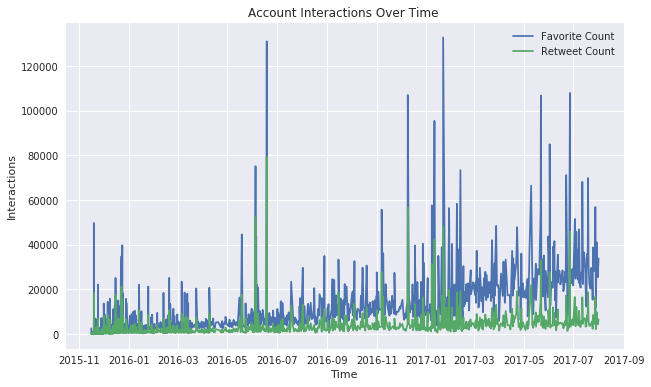

In [72]:
df_merged_copy = df_merged.copy()

avg_retweet_count= df_merged_copy.groupby('timestamp').retweet_count.mean()

avg_favorite_count = df_merged_copy.groupby('timestamp').favorite_count.mean()  

x2= df_merged_copy['timestamp']
x3= df_merged_copy['timestamp']

y2= df_merged_copy['favorite_count']
y3= df_merged_copy['retweet_count']

plt.plot(x2, y2, label = "Favorite Count")
plt.plot(x3, y3, label = "Retweet Count")

plt.xlabel('Time')
plt.ylabel('Interactions')

plt.title('Account Interactions Over Time ')
plt.legend()
plt.show()

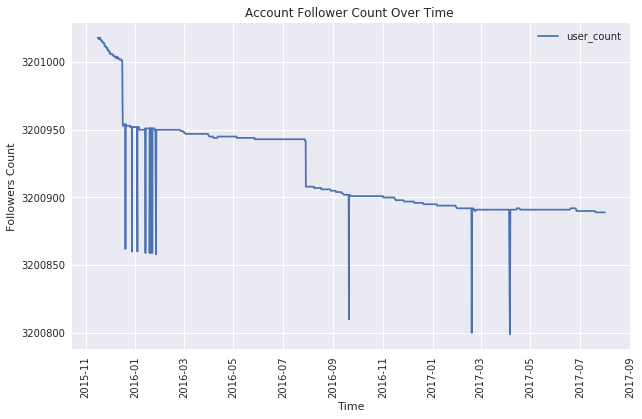

In [73]:
df_merged_copy = df_merged_copy.sort_values('timestamp', ascending=True)
avg_user_count= df_merged_copy.groupby('timestamp').user_count.mean()
plt.plot(df_merged_copy['timestamp'], df_merged_copy['user_count'])
plt.xticks(rotation='vertical')
plt.xlabel('Time')
plt.ylabel('Followers Count')

plt.title('Account Follower Count Over Time ')
plt.legend()
plt.show()

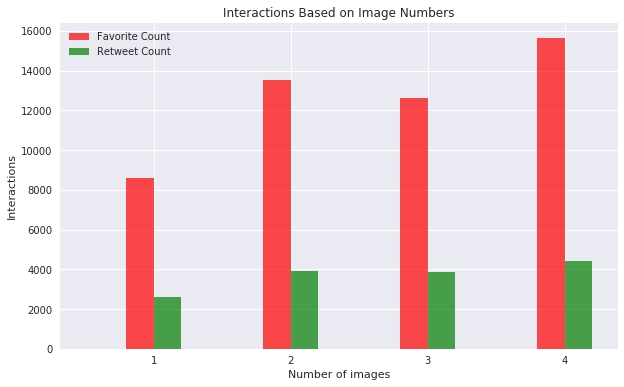

In [74]:

avg_retweet_img= df_merged_copy.groupby('img_num').retweet_count.mean()
avg_retweet_img.index
avg_favorite_img = df_merged_copy.groupby('img_num').favorite_count.mean()

width = 0.2
ind = np.arange(len(avg_favorite_img))
locations = ind + width / 2
labels = ['1', '2', '3', '4']

favorite_bars = plt.bar(ind, avg_favorite_img, width, color='r', alpha=.7, label='Favorite Count')
retweet_bars = plt.bar(ind + width, avg_retweet_img, width, color='g', alpha=.7, label='Retweet Count')
plt.xlabel('Number of images')
plt.ylabel('Interactions')

plt.title('Interactions Based on Image Numbers')
plt.bar(x="df_merged_copy['img_num']", height=ind )
plt.xticks(locations, labels)

plt.legend();

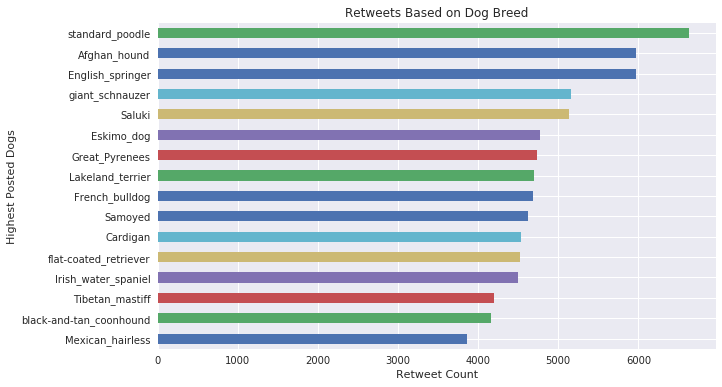

In [75]:
breed_avg_retweet = df_merged_copy.groupby(['breed']).retweet_count.mean().sort_values(ascending=False)[15::-1]
breed_avg_retweet.plot(kind='barh')
plt.ylabel('Highest Posted Dogs')
plt.xlabel('Retweet Count')

plt.title('Retweets Based on Dog Breed');

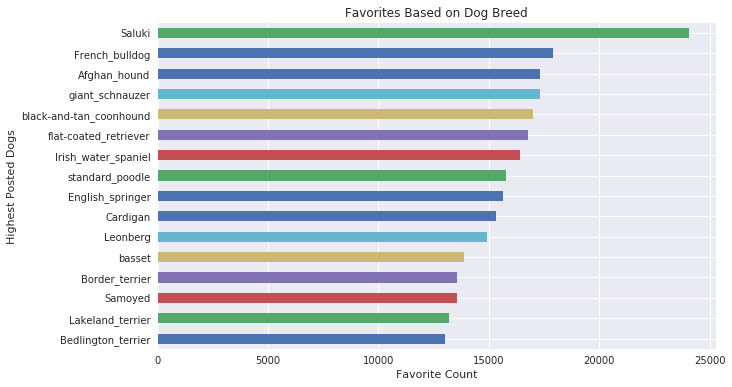

In [76]:
breed_avg_favorite =df_merged_copy.groupby(['breed']).favorite_count.mean().sort_values(ascending=False)[15::-1]
breed_avg_favorite.plot(kind='barh')
plt.ylabel('Highest Posted Dogs')
plt.xlabel('Favorite Count')

plt.title('Favorites Based on Dog Breed');

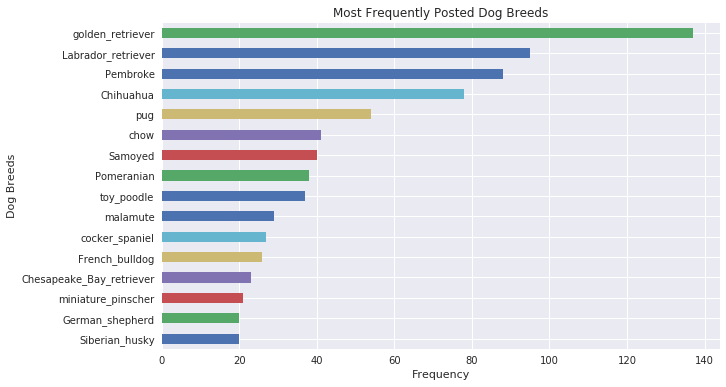

In [77]:
most_frequent_breed = df_merged_copy['breed'].value_counts(ascending=False)[15::-1]
most_frequent_breed.plot(kind='barh')
plt.ylabel('Dog Breeds')
plt.xlabel('Frequency')

plt.title('Most Frequently Posted Dog Breeds');